In [5]:
import os
import sys
import re
import tqdm
from dotenv import load_dotenv
import supervision as sv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

load_dotenv('.env')
DIR_SRC = os.getenv('DIR_SRC')
DIR_DATA = os.path.join(os.getenv('DIR_DATA'), "final")
MULTIPLIER = 1000 # resize the iamge for visualization

In [2]:
def txt_2_xy(path_txt):
    ls_dets = [] # x, y
    with open(path_txt, "r") as f:
        lines = f.readlines()
        for line in lines:
            # remove space
            ls = line.strip().split(" ")
            ls = [float(l) for l in ls]
            ls_dets.append((ls[1], ls[2])) # x, y
    return ls_dets

def dets_2_cat(ls_det, a, b):
    # turn detections to category
    cat_0 = 0
    cat_1 = 0
    for det in ls_det:
        x, y = det
        x *= MULTIPLIER
        y *= MULTIPLIER
        y_pred = -a * x + b
        if y > y_pred:
            # upper side
            cat_1 += 1
        else:
            # lower side
            cat_0 += 1
    return cat_0, cat_1

def vis_eq(img, a, b):
    W = img.width
    H = img.height
    x = np.arange(0, W)
    y = -a * x + b
    y = np.clip(y, 0, H - 1)
    y = y.astype(int)
    plt.imshow(img)
    plt.plot(x, y, color="red", linewidth=2)
    plt.show()
    
def test_eq(a, b, i, df):
    # image
    path_img = df.iloc[i].loc["path_img"]
    img = Image.open(path_img).resize((MULTIPLIER, MULTIPLIER))
    vis_eq(img, a, b)
    # labels
    path_txt = df.iloc[i].loc["path_txt"]
    ls_dets = txt_2_xy(path_txt)
    print(dets_2_cat(ls_dets, a, b))


def append_suc_pep(df, a, b):
    ls_suc, ls_pep = [], []
    for i, row in df.iterrows():
        path_txt = row["path_txt"]
        ls_dets = txt_2_xy(path_txt)
        pep, suc = dets_2_cat(ls_dets, a, b)
        ls_suc += [suc]
        ls_pep += [pep]
    df.loc[:, "suc"] = ls_suc
    df.loc[:, "pep"] = ls_pep
    return df

def append_basedate(df):
    base_datetime = df.iloc[0].loc["datetime"]
    rel_hours = (df.datetime - base_datetime).dt.total_seconds() / 3600
    df.loc[:, "rel_hours"] = rel_hours
    return df

In [3]:
metadata = pd.read_csv(os.path.join(DIR_SRC, "metadata.csv"))
os.chdir(DIR_DATA)

# test_a03

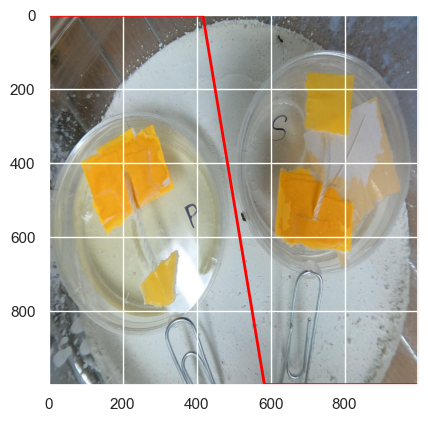

(2, 1)


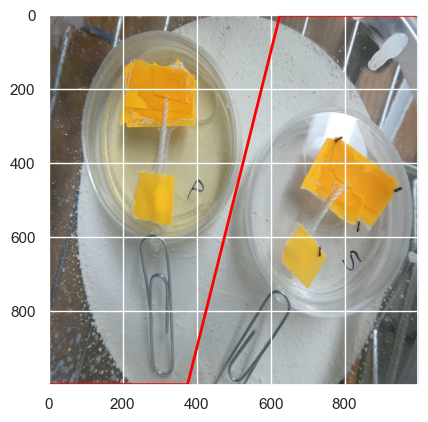

(0, 4)


In [7]:
# test_a03 ---------------------------------------------
split = "test_a03"
df_sub = metadata.query("split == @split").sort_values("datetime")
df_sub.datetime = pd.to_datetime(df_sub.datetime)
## control
df_sub_ctrl = df_sub.query("prefix == 'ctrl'")
a = -6
b = -2500
test_eq(a=a, b=b, i=5, df=df_sub_ctrl)
df_sub_ctrl = append_suc_pep(df_sub_ctrl, a, b)
df_sub_ctrl = append_basedate(df_sub_ctrl)

## virus
df_sub_vir = df_sub.query("prefix == 'virus'")
a = 4
b = 2500
test_eq(a=a, b=b, i=5, df=df_sub_vir)
df_sub_vir = append_suc_pep(df_sub_vir, a, b)
df_sub_vir = append_basedate(df_sub_vir)


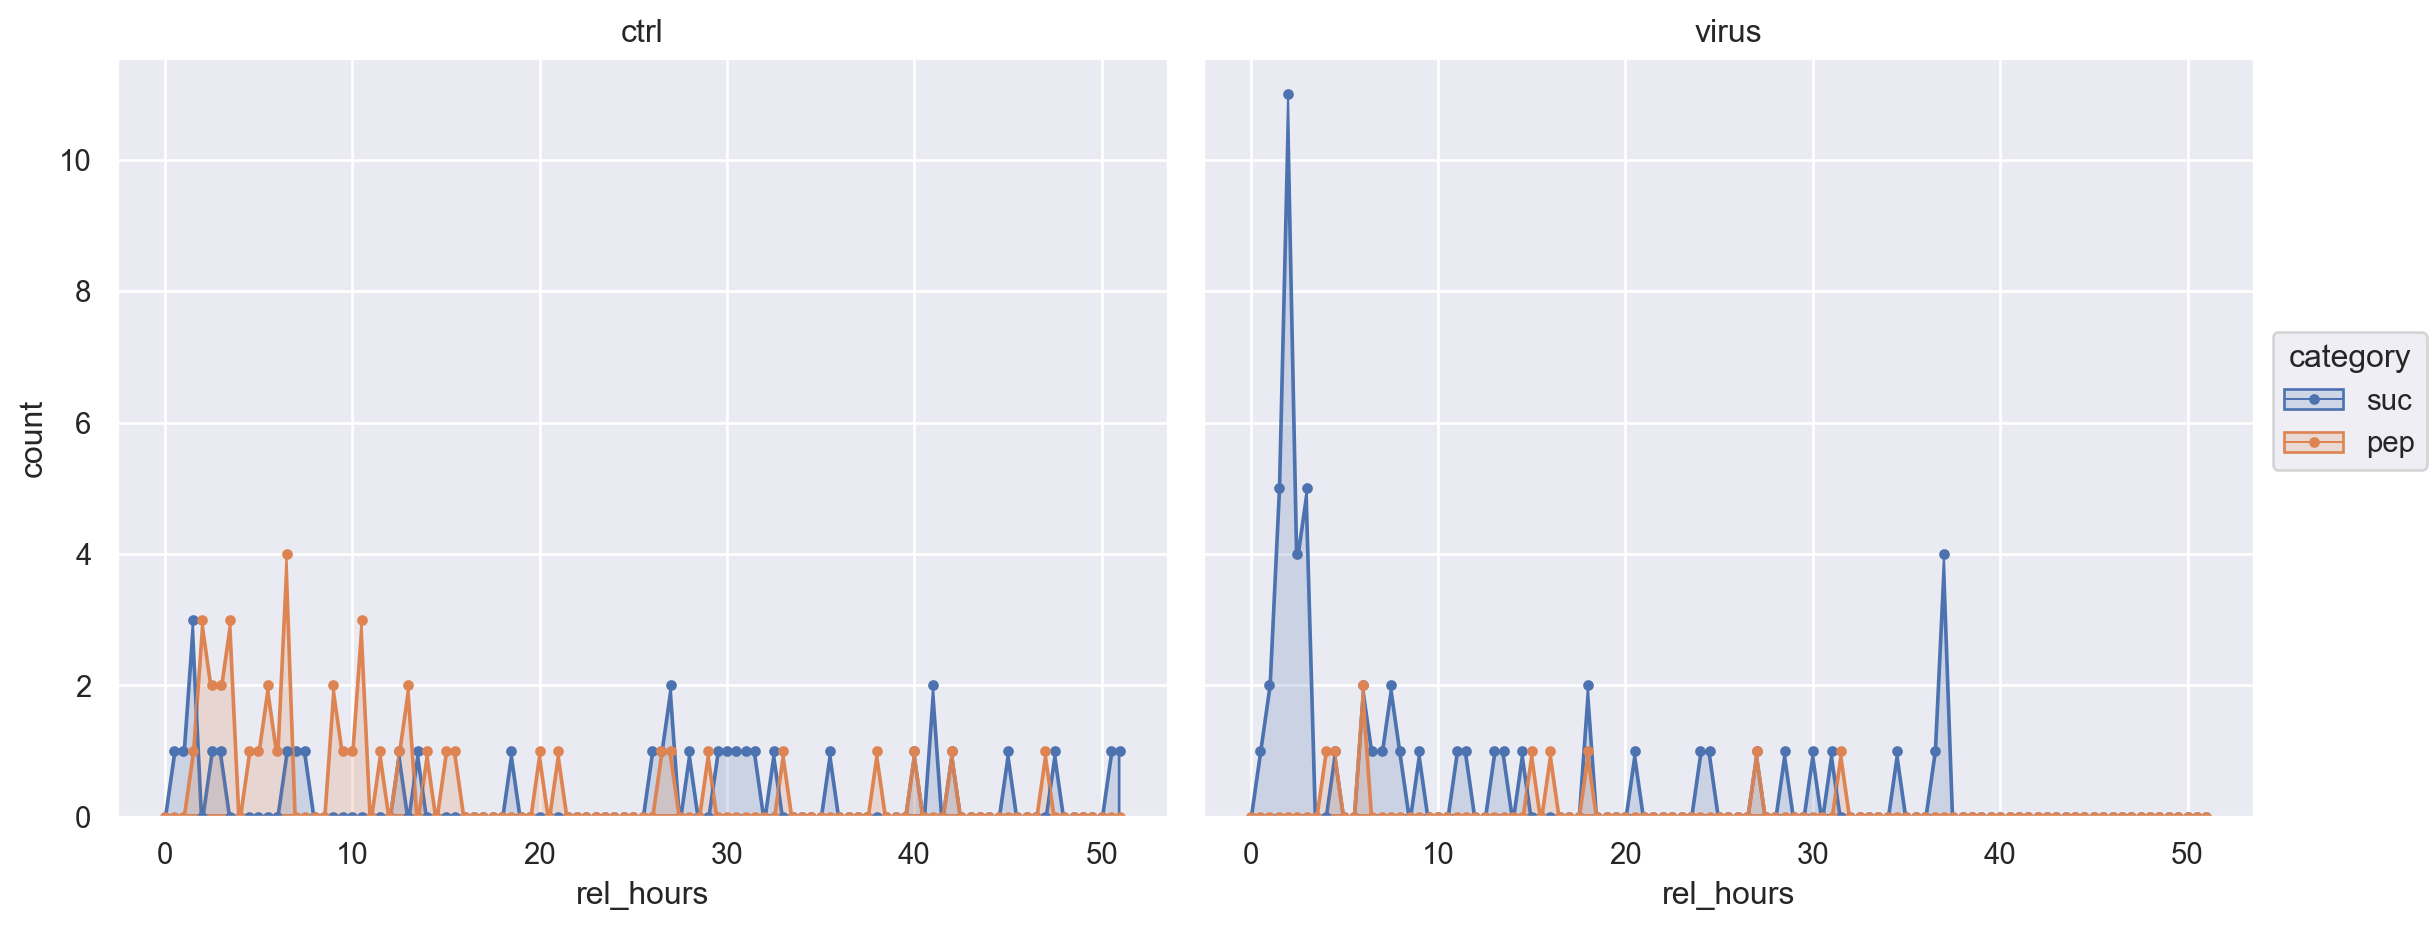

In [36]:
## plot
df_plot = pd.concat([df_sub_ctrl, df_sub_vir]).loc[:, ["prefix", "rel_hours", "suc", "pep"]]
df_plot["prefix"].unique()
df_plot_long = df_plot.melt(id_vars=["prefix", "rel_hours"], value_vars=["suc", "pep"], var_name="category", value_name="count")
from seaborn import objects as so
sns.set_theme("notebook")
p = so.Plot(df_plot_long, "rel_hours", "count").\
    facet("prefix").\
        add(so.Area(), color="category").\
        add(so.Path(marker="o", pointsize=3, linewidth=.75), fillcolor="category", color="category").\
            layout(size=(12, 5))
                
p

## test_b06

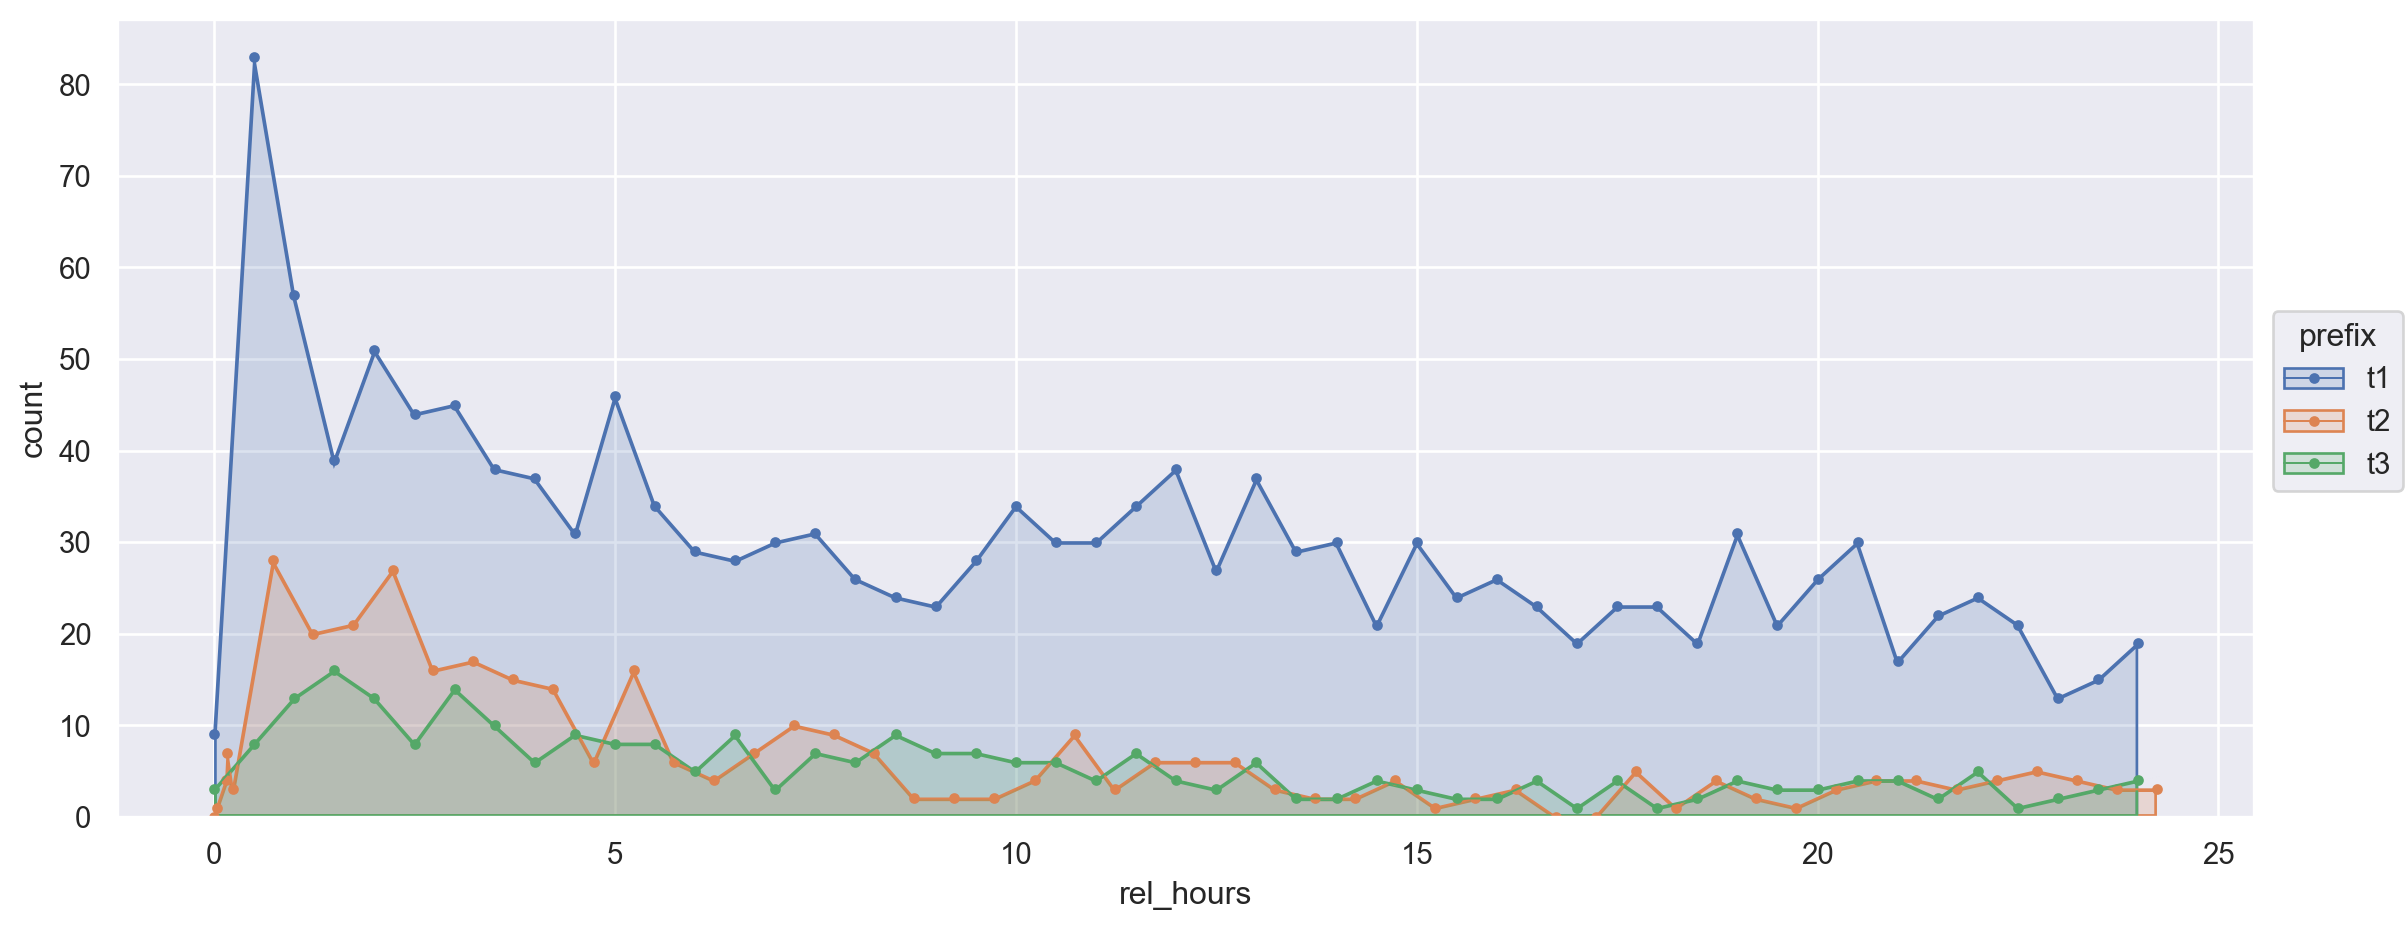

In [29]:
split = "test_b06"
df_sub = metadata.query("split == @split").sort_values("datetime")
df_sub.datetime = pd.to_datetime(df_sub.datetime)
# t1
df_t1 = df_sub.query("prefix == 't1'")
df_t1 = append_basedate(df_t1)
df_t2 = df_sub.query("prefix == 't2'")
df_t2 = append_basedate(df_t2)
df_t3 = df_sub.query("prefix == 't3'")
df_t3 = append_basedate(df_t3)
df_plot = pd.concat([df_t1, df_t2, df_t3]).loc[:, ["prefix", "rel_hours", "count"]]

## compare prefix: t1 t2 t3 in different hue in the same plot
## no facet needed
sns.set_theme("notebook")
p = so.Plot(df_plot, "rel_hours", "count").\
    add(so.Path(marker="o", pointsize=3, linewidth=.75), fillcolor="prefix", color="prefix").\
        layout(size=(12, 5)).\
            add(so.Area(), color="prefix")
p